In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift


In [3]:
data = r"..\data\training_data_w=3000_sample1.pkl"
df = pd.read_pickle(data)

In [4]:
df = df.iloc[0]

##### Plotting the frequency spectrum 

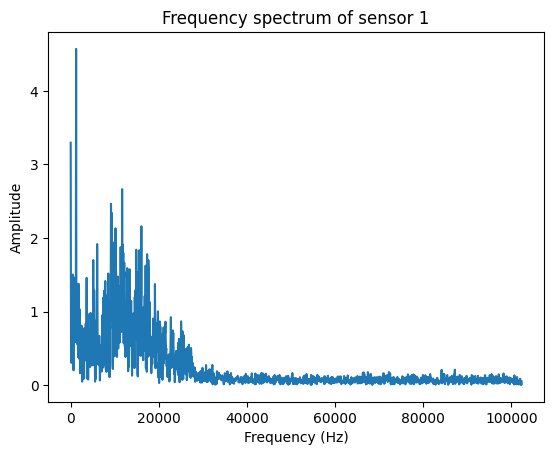

In [5]:
# calculating the frequency spectrum for sensor 1 and plotting 
sampling_rate = 204800
n = len(df['sensor_1'])
timestep = 1/sampling_rate
frequencies = np.fft.fftfreq(n, d=timestep)
frequencies = frequencies[:n//2]

# calculating the frequency spectrum for sensor 1 and plotting
sensor1 = df['sensor_1']
sensor1_fft = np.fft.fft(sensor1)
sensor1_fft = sensor1_fft[:n//2]
plt.plot(frequencies, np.abs(sensor1_fft))
plt.title('Frequency spectrum of sensor 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()



##### Plotting the signal

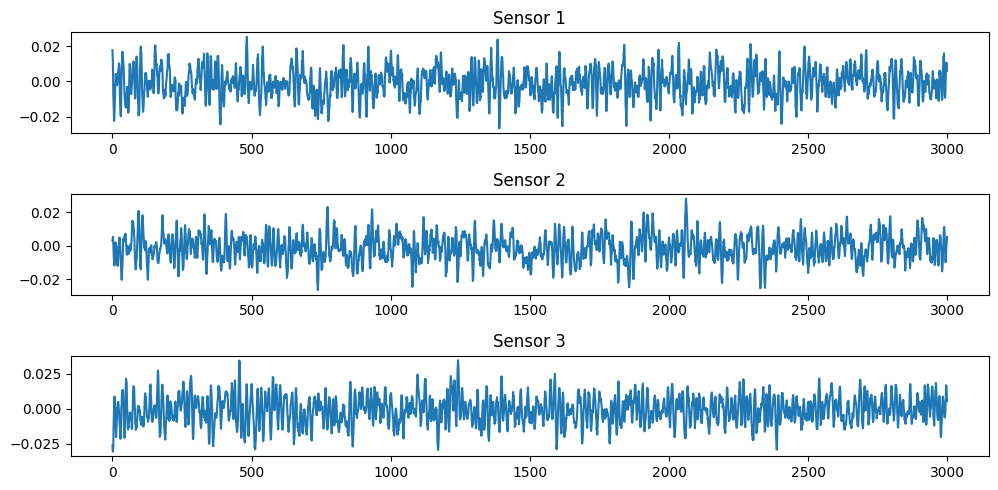

In [63]:
fig, ax = plt.subplots(3,1,figsize=(10,5))
ax = ax.ravel()
ax[0].plot(df.sensor_1) 
ax[0].set_title('Sensor 1')
ax[1].plot(df.sensor_2)
ax[1].set_title('Sensor 2')
ax[2].plot(df.sensor_3)
ax[2].set_title('Sensor 3')
plt.tight_layout()
plt.show()


##### Building the sinc filters

In [64]:
def flip(x, dim):
    return np.flip(x, axis=dim)

def time(t_right): 
    t_left = flip(-t_right, 0)
    t = np.concatenate([t_left, np.array([0]), t_right])
    return t

def sinc(band, t_right):
    y_right = np.sin(2 * np.pi * band * t_right) / (2 * np.pi * band * t_right)
    y_right[np.isnan(y_right)] = 1.0
    y_left = flip(y_right, 0)
    y = np.concatenate([y_left, np.ones((1,)), y_right])
    return y

In [ ]:
low_frequency = 2000
high_frequency = 30000
bands = np.linspace(low_frequency, high_frequency, 10)
for band in bands:

    t_right = np.linspace(0, 0.001, 1000)
    t = time(t_right)
    y = sinc(band, t_right)

    plt.plot(t, y)
    plt.title('Sinc function')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

##### Convolving sinc function with time signal

In [6]:
# applying sinc filter to sensor 1
sampling_rate = 204800
dt = 1/sampling_rate
w = 1000
step = 1000
factor = 100/w
beta = 1
window_type = signal.windows.boxcar
corr_type = np.real

def apply_filter(sensor, band):
    t_right = np.arange(0, w*dt, dt)
    t = time(t_right)
    y = sinc(band, t_right)
    filtered = np.convolve(sensor, y, mode='same')
    return filtered



In [7]:
def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift

##### Applying FIRWIN filter 

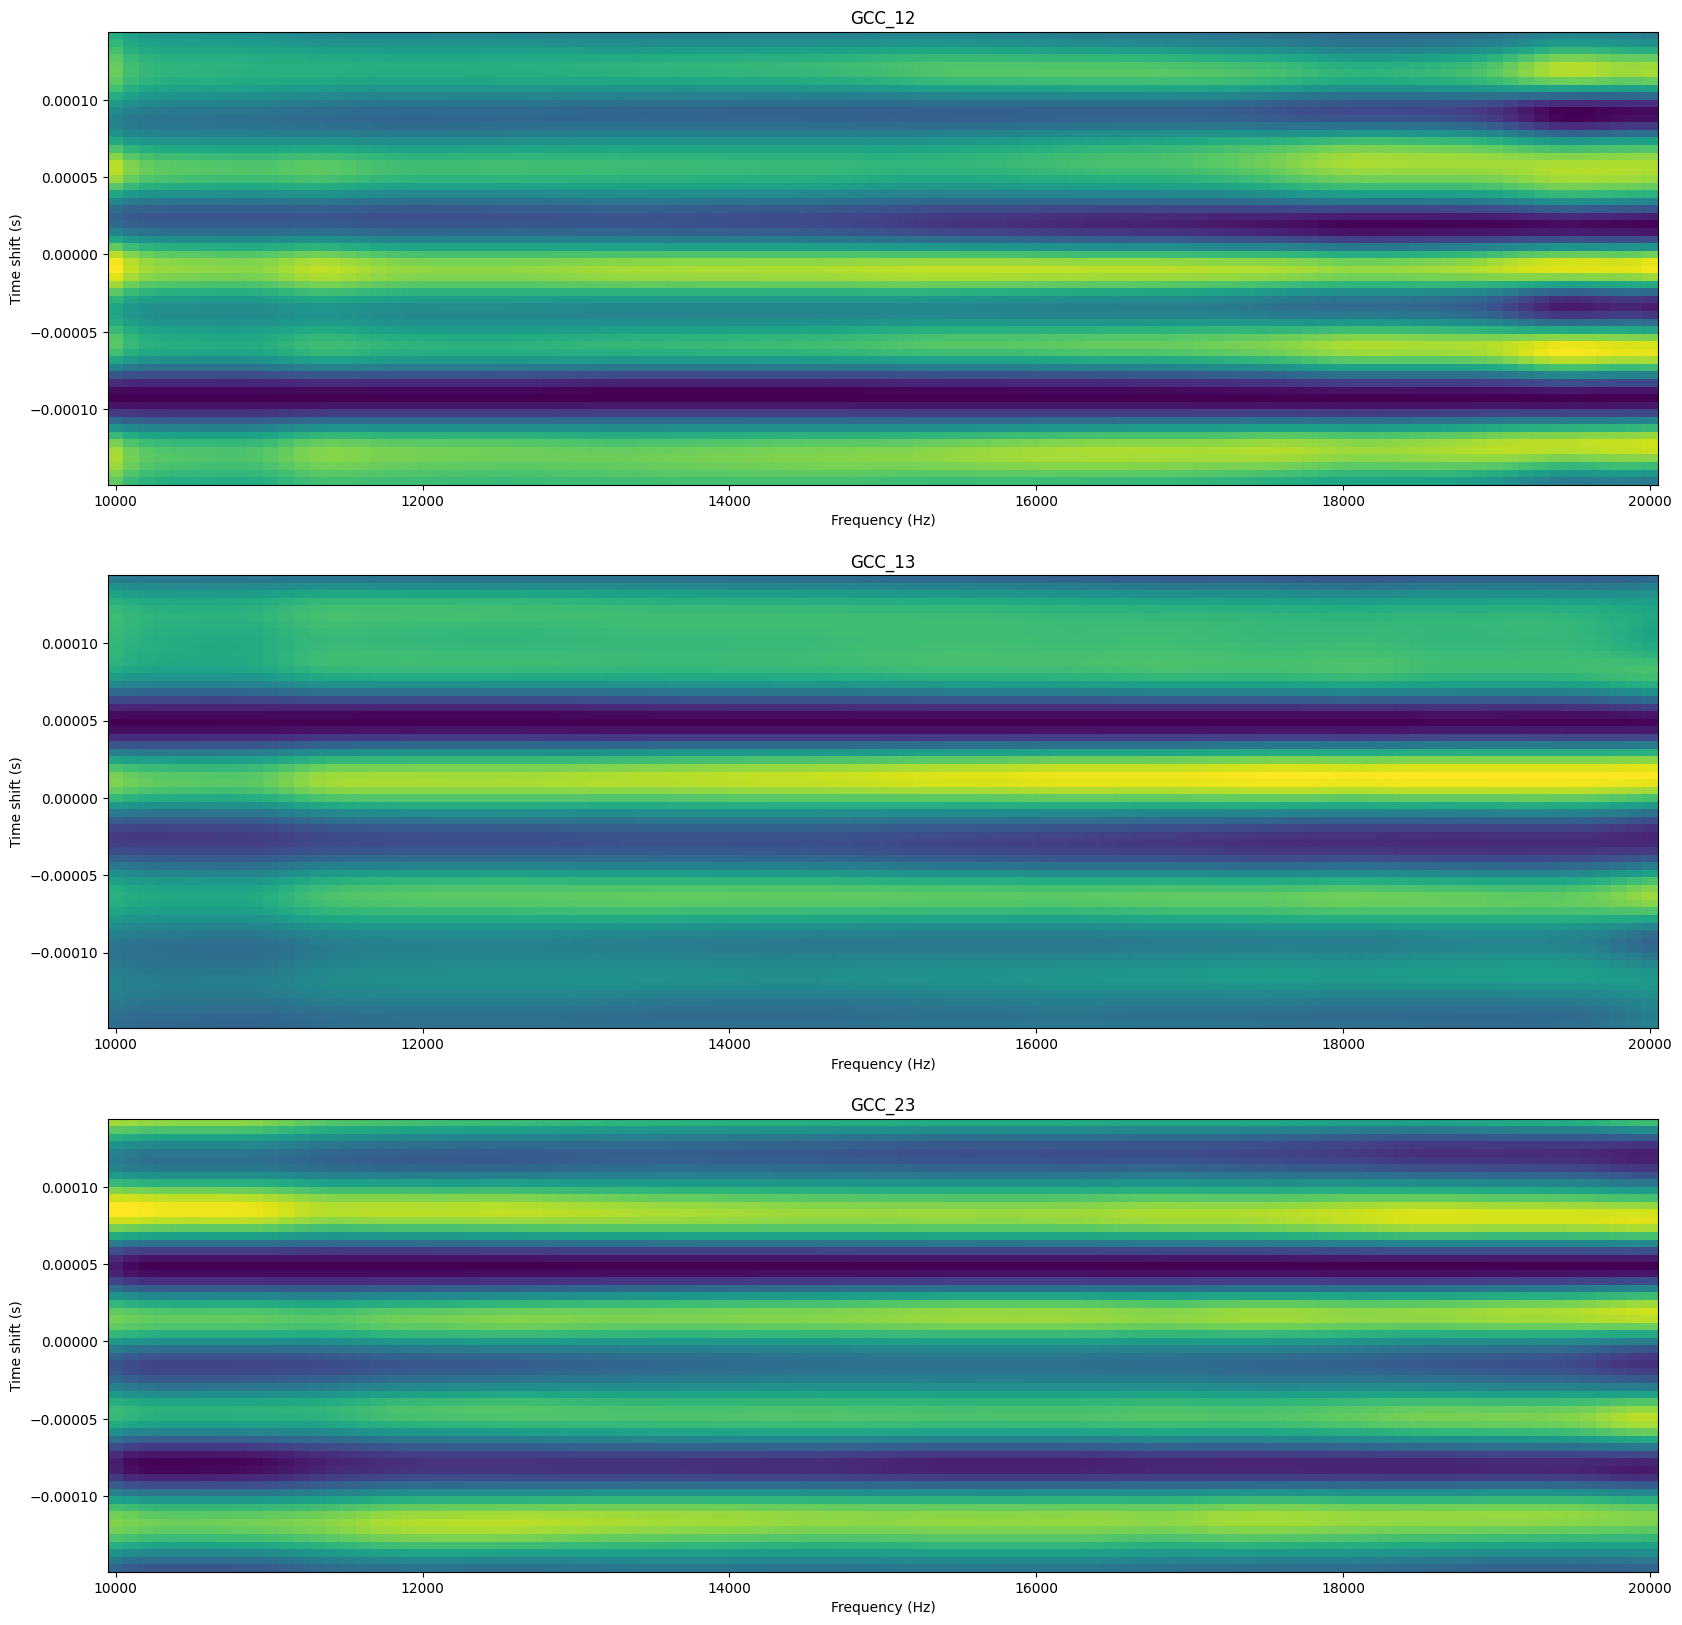

In [13]:
frequencies = np.linspace(10000, 20000, 100)
numtaps = 701
truncate_length = 60
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
output_folder = r"../testing_sinc_net"

band_width = 20000-1
filters = []



# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero=False)
    filters.append(h)


#applying filter to sensor 1 and 2, calculating the GCC, and plotting the result
    sensor1 = df['sensor_2']
    sensor2 = df['sensor_3']

def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in filters:
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)
        '''
        frequency_spectrum_1 = np.fft.rfft(s1)
        frequency_spectrum_2 = np.fft.rfft(s2)

        fig, ax = plt.subplots(1,2,figsize=(20,5))

        ax[0].plot(np.abs(frequency_spectrum_1))
        ax[0].set_title('Frequency spectrum of sensor 1')
        ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_ylabel('Amplitude')

        ax[1].plot(np.abs(frequency_spectrum_2))
        ax[1].set_title('Frequency spectrum of sensor 2')
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Amplitude')
        ax[0].set_ylim(0,1)
        ax[1].set_ylim(0,1)
        
        

        title = f'Filter  frequency {frequencies[i]} Hz'    
        i += 1
        fig.suptitle(title)
        plt.savefig(f'{output_folder}/{title}.png')
        plt.close()'''



        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta

        f_s = G12

        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12

GCC_12 = GCC(df.sensor_1, df.sensor_2)
GCC_13 = GCC(df.sensor_1, df.sensor_3)
GCC_23 = GCC(df.sensor_2, df.sensor_3)


time_shifts = np.arange(-w*dt,w*dt,dt)

time_shifts = truncate_time_shift(time_shifts, truncate_length)
fig, ax = plt.subplots(3,1,figsize=(20,20))
ax = ax.ravel()


ax[0].set_title('GCC_12')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Time shift (s)')
ax[0].pcolormesh(frequencies, time_shifts, GCC_12.T, shading='auto')

ax[1].set_title('GCC_13')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Time shift (s)')
ax[1].pcolormesh(frequencies, time_shifts, GCC_13.T, shading='auto')

ax[2].set_title('GCC_23')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Time shift (s)')
ax[2].pcolormesh(frequencies, time_shifts, GCC_23.T, shading='auto')

plt.savefig(f'{output_folder}/GCC.png')
